In [1]:
import os
import numpy as np 
import pandas as pd 
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAvgPool2D, ReLU, Flatten, Reshape, Lambda, Embedding, LSTM, GRU, Conv2D, MaxPool2D, TimeDistributed, RepeatVector, Concatenate, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

from scipy import ndimage, misc
from PIL import Image
import imageio
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from datetime import datetime
import json
from sklearn.model_selection import train_test_split

from IPython.display import clear_output 
from IPython.core.interactiveshell import InteractiveShell  # print all outputs
InteractiveShell.ast_node_interactivity = "all"



In [ ]:
SEED = 1234
tf.random.set_seed(SEED)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
curr_dir = os.getcwd()
dataset_dir = curr_dir
dataset_dir 
images_dir = dataset_dir + '/Images/'
images_dir

'/content'

'/content/Images/'

In [4]:
!unzip '/content/gdrive/My Drive/Colab Notebooks/VQA_Dataset.zip'

Output streaming troncato alle ultime 5000 righe.
  inflating: Images/5390.png         
  inflating: Images/5391.png         
  inflating: Images/5392.png         
  inflating: Images/5393.png         
  inflating: Images/5394.png         
  inflating: Images/5395.png         
  inflating: Images/5396.png         
  inflating: Images/5397.png         
  inflating: Images/5398.png         
  inflating: Images/5399.png         
  inflating: Images/54.png           
  inflating: Images/540.png          
  inflating: Images/5400.png         
  inflating: Images/5401.png         
  inflating: Images/5402.png         
  inflating: Images/5403.png         
  inflating: Images/5404.png         
  inflating: Images/5405.png         
  inflating: Images/5406.png         
  inflating: Images/5407.png         
  inflating: Images/5408.png         
  inflating: Images/5409.png         
  inflating: Images/541.png          
  inflating: Images/5410.png         
  inflating: Images/5411.png         


In [ ]:
# Image preprocessing (not applied)
def process_image(x):
    target_height, target_width = 256, 256
    rotation_range = .05 # In radians
    degs = random.uniform(-rotation_range, rotation_range)

    x = tf.image.resize(x, (target_height, target_width), method=tf.image.ResizeMethod.AREA)
    #x = tfa.image.rotate(x, degs)
    return x

In [5]:
# used to randomly get the training and validation dictionary 
def train_valid_split_custom(df, train_size):
    train_dic = {}
    valid_dic = {}
    count = 0
    train_df, valid_df = train_test_split(df, shuffle = True, train_size = train_size)
    train_dic = train_df.set_index('question_id').T.to_dict('dict')
    valid_dic = valid_df.set_index('question_id').T.to_dict('dict') 
    return train_dic,valid_dic        

In [6]:
# Get the training data
questions = []
image_id = []
answer = []

training_dir = os.path.join(dataset_dir, 'training')

with open(os.path.join(dataset_dir,"train_questions_annotations.json")) as f:
    dic = json.load(f)
df = pd.DataFrame(dic.items())
df.rename(columns = {0:'question_id', 1:'question', 2:'image_id', 3:'answer'}, inplace = True)
for img_id in df['question_id']:
    questions.append(dic[img_id]['question'])
    image_id.append(dic[img_id]['image_id'])
    answer.append(dic[img_id]['answer'])
df['question'] = questions
df['image_id'] = image_id
df['answer'] = answer

train_data, valid_data= train_valid_split_custom(df, train_size = 0.95)
 

In [ ]:
len(valid_data)

2942

In [ ]:
# Dataset analysis: 
# Helpful to tune the hyper-parameters for the Embedding and the LSTM
# - check the number of different words that appear in the questions => 4965
# - check the maximum number of characters for a question => 100


varie = []
for string in df.question:
  list_str = string.split()
  for i in list_str:
    if(i not in varie):
      i = i.strip('?')
      varie.append(i)
    

In [ ]:
set_ = set(varie)
len(set_)

4965

In [ ]:
lista = max(list(df.question), key=len)
len(lista)
print('\n' + lista)


100


Are tall pointed ears traditional to another animal that lives outdoors and has a bushy orange tail?


In [7]:
# Our dictionary

labels_dict = {
        '0': 0,
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '5': 5,
        'apple': 6,
        'baseball': 7,
        'bench': 8,
        'bike': 9,
        'bird': 10,
        'black': 11,
        'blanket': 12,
        'blue': 13,
        'bone': 14,
        'book': 15,
        'boy': 16,
        'brown': 17,
        'cat': 18,
        'chair': 19,
        'couch': 20,
        'dog': 21,
        'floor': 22,
        'food': 23,
        'football': 24,
        'girl': 25,
        'grass': 26,
        'gray': 27,
        'green': 28,
        'left': 29,
        'log': 30,
        'man': 31,
        'monkey bars': 32,
        'no': 33,
        'nothing': 34,
        'orange': 35,
        'pie': 36,
        'plant': 37,
        'playing': 38,
        'red': 39,
        'right': 40,
        'rug': 41,
        'sandbox': 42,
        'sitting': 43,
        'sleeping': 44,
        'soccer': 45,
        'squirrel': 46,
        'standing': 47,
        'stool': 48,
        'sunny': 49,
        'table': 50,
        'tree': 51,
        'watermelon': 52,
        'white': 53,
        'wine': 54,
        'woman': 55,
        'yellow': 56,
        'yes': 57
}

In [8]:
# Some hyper-parameters

img_h, img_w = 400, 700
batch_size = 16          # We also tried 32
vocab_size = 4000        # Number of words in the question vocabulary 
sequence_length = 100    # Number of characters in the question (We also tried 64)
test_samples = 6372
n_classes = len(labels_dict)
INPUT_SIZE_MERGE = 512   # Number of LSTM & neurons in Dense layers
ensemble = True

In [9]:
# Fit a tokenizer on the whole training questions 

TOKEN = Tokenizer(num_words=vocab_size)   # Tokens to the text
TOKEN.fit_on_texts(df['question']) 

In [10]:
# Custom data train generator
def custom_generator(data, tokenizer):
    while True:
        n = batch_size
        batch_data = []
        x_text = []             # List of questions
        x_image = []            # List of images
        y = []                  # List of answers
        num_labels = n_classes  # Current number of labels, used to create index mapping
        images = {}             # Dictionary of images, to minimize number of imread ops


        batch_data.append(random.sample(list(data), n))   # create batch of size n

        for q in batch_data[0][0:n]:                      # take the first batch
            if not data[q]['image_id'] in images:         # some images are already loaded (there might be questions on the same image)               
                images[data[q]['image_id']] = imageio.imread(images_dir + data[q]['image_id']+'.png', pilmode="RGB")

            x_text.append(data[q]['question'])
            x_image.append(images[data[q]['image_id']])
            y.append(labels_dict[data[q]['answer']])
       
        sequences = tokenizer.texts_to_sequences(x_text)
        x_text = sequence.pad_sequences(sequences, maxlen=sequence_length)     # Have all words with same length

        # Convert x_image to np array
        x_image = np.array(x_image)
        
        # Convert labels to categorical labels
        y = keras.utils.to_categorical(y, num_labels)
        yield ([x_text, x_image], y)

In [ ]:
# Plot the images

gen = custom_generator(train_data,TOKEN)
dataset = iter(gen)


In [ ]:
[x_text, x_image], y = next(dataset)

(32, 100)

(32, 400, 700, 3)

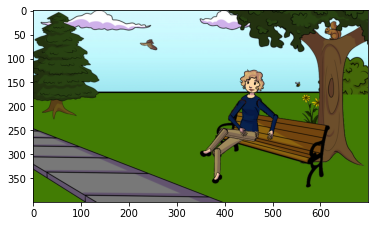

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.imshow(np.uint8(x_image[0]))
x_text.shape 
x_image.shape

## Build the Model

In [12]:
# Define CNN for Image Input => Transfer Learning with fine-tuning

base_model = tf.keras.applications.VGG16(input_shape=(img_h, img_w, 3), include_top=False, weights='imagenet')
for i in range(16):
    base_model.layers[i].trainable = False
    

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
vision_model = Sequential()
vision_model.add(base_model)
vision_model.add(GlobalAvgPool2D())
vision_model.add(Dense(INPUT_SIZE_MERGE, activation='relu'))
vision_model.add(Dropout(0.2))

image_input = Input(shape=(img_h, img_w, 3))
encoded_image = vision_model(image_input)

# Define RNN for language input
question_input = Input(shape=[sequence_length])
embedded_question = Embedding(vocab_size, 128)(question_input)
encoded_question = Bidirectional(LSTM(INPUT_SIZE_MERGE))(embedded_question)    #we also tried GRU
encoded_question = Dense(INPUT_SIZE_MERGE, activation='tanh')(encoded_question)
encoded_question = Dropout(0.2)(encoded_question)
encoded_question = Dense(INPUT_SIZE_MERGE/2, activation='tanh')(encoded_question)

# Combine CNN and RNN to create the final model
merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
output = Dense(INPUT_SIZE_MERGE/2, activation='relu')(merged)
output = Dropout(0.2)(output)
#output = Dense(INPUT_SIZE_MERGE/4, activation='relu')(output)
output = Dense(n_classes, activation='softmax')(output)
vqa_model = Model(inputs=[question_input, image_input], outputs=output)

vqa_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     512000      input_3[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 1024)         2625536     embedding[0][0]                  
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          524800      bidirectional[0][0]              
______________________________________________________________________________________________

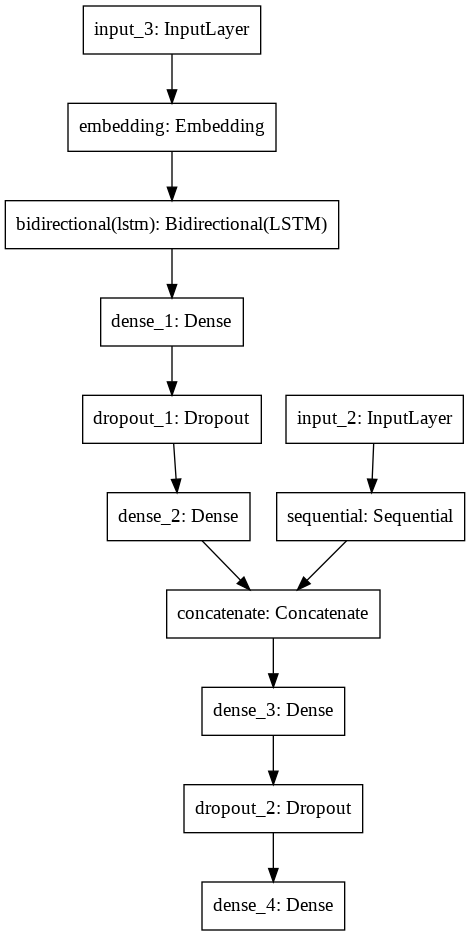

In [ ]:
tf.keras.utils.plot_model(vqa_model)

## Prepare the model for training

In [14]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy() 

# learning rate
lr = 1e-3

optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = ['accuracy']
# ------------------

# Compile Model
vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Training with callbacks

In [15]:
# Early Stopping
# --------------
callbacks = []
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    callbacks.append(es_callback)


In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [17]:
# Setting up the Ensemble:
# 1) For every model build a different dataset

def generate_random_dataset(dataset):
    rand_data= {}
    copy = 1
    for i in range(len(dataset)):
      key = random.choice(list(dataset.keys()))
      if(key in rand_data.keys()):
        rand_data[key + '_' + str(copy)] = dataset[key]
        copy += 1
      else:
        rand_data[key] = dataset[key]
    return rand_data

In [18]:
# 2) Build a single VQA model

def build_vqa():
  base_model = tf.keras.applications.VGG16(input_shape=(img_h, img_w, 3), include_top=False, weights='imagenet')
  for i in range(16):
    base_model.layers[i].trainable = False

  vision_model = Sequential()
  vision_model.add(base_model)
  vision_model.add(GlobalAvgPool2D())
  vision_model.add(Dense(1024, activation='relu'))
  vision_model.add(Dropout(0.2))

  image_input = Input(shape=(img_h, img_w, 3))
  encoded_image = vision_model(image_input)

  # Define RNN for language input
  question_input = Input(shape=[sequence_length])
  embedded_question = Embedding(vocab_size, 128)(question_input)
  encoded_question = Bidirectional(LSTM(1024))(embedded_question)  #try GRU instead LSTM
  encoded_question = Dense(1024/2, activation='tanh')(encoded_question)
  encoded_question = Dropout(0.2)(encoded_question)

  # Combine CNN and RNN to create the final model   
  merged = tf.keras.layers.concatenate([encoded_question, encoded_image])
  output = Dense(1024/2, activation='relu')(merged)
  output = Dropout(0.3)(output)
  output = Dense(n_classes, activation='softmax')(output)
  vqa_model = Model(inputs=[question_input, image_input], outputs=output)
  return vqa_model 

In [19]:
# 3) Create and fit 3 models and return them

def ensemble_NN(n_networks = 3, tokenizer = None):
  # Loss
  loss = tf.keras.losses.CategoricalCrossentropy() 

  # learning rate
  lr = 1e-4

  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  # Validation metrics
  metrics = ['accuracy']

  models = [None]*n_networks
  for i in range(n_networks):
    models[i] = build_vqa()
    print("Model  "+ str(i+1) + " out of "+str(n_networks)+"  has been built")
    
    models[i].compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print("Model  "+ str(i+1) + " out of "+str(n_networks)+"  has been compiled" '\n')
    
    data_train = generate_random_dataset(train_data)
    data_valid = generate_random_dataset(valid_data)
    
    models[i].fit(x=custom_generator(data_train, tokenizer),
          epochs = 7, 
          steps_per_epoch = len(data_train)//batch_size,
          validation_data = custom_generator(data_valid, tokenizer),
          validation_steps = len(data_valid)//batch_size)
    
    print('\n' "Model  "+ str(i+1) + " out of "+str(n_networks)+"  has been fit" '\n')
    
  return models
    

In [20]:
# 4) Computes the mean of the 3 ensemble for each data point

def predict_ensembleNN(models, test):
  out_softmax = [[None]*58]*(len(models))
  out_softmax = np.array(out_softmax)
  final_softmax = np.array([None]*58)

  for i in range(len(models)):
    out_softmax[i] = models[i].predict(test)

  out_softmax = np.array(out_softmax)

  for i in range(58):
   final_softmax[i] = np.mean(out_softmax[:,i])

  return final_softmax.argmax(axis=-1)


In [21]:
# Train the model/models

if(ensemble == False):
  vqa_model.fit(x=custom_generator(train_data, TOKEN),
  epochs = 20,
  steps_per_epoch = len(train_data)//batch_size,
  validation_data = custom_generator(valid_data, TOKEN),
  validation_steps = len(valid_data)//batch_size,
  callbacks = callbacks)
else:  
  models = ensemble_NN(n_networks = 3,tokenizer = TOKEN)

Model  1 out of 3  has been built
Model  1 out of 3  has been compiled

Epoch 1/7
3493/3493 [==============================] - 1497s 425ms/step - loss: 2.1230 - accuracy: 0.3648 - val_loss: 1.3398 - val_accuracy: 0.4795
Epoch 2/7
3493/3493 [==============================] - 1484s 425ms/step - loss: 1.2922 - accuracy: 0.5117 - val_loss: 1.1074 - val_accuracy: 0.5574
Epoch 3/7
3493/3493 [==============================] - 1485s 425ms/step - loss: 1.0677 - accuracy: 0.5874 - val_loss: 1.0874 - val_accuracy: 0.5478
Epoch 4/7
3493/3493 [==============================] - 1483s 425ms/step - loss: 0.9308 - accuracy: 0.6409 - val_loss: 1.0249 - val_accuracy: 0.5748
Epoch 5/7
3493/3493 [==============================] - 1484s 425ms/step - loss: 0.7944 - accuracy: 0.6843 - val_loss: 1.1055 - val_accuracy: 0.5666
Epoch 6/7
3493/3493 [==============================] - 1483s 425ms/step - loss: 0.6734 - accuracy: 0.7400 - val_loss: 1.0574 - val_accuracy: 0.5936
Epoch 7/7
3493/3493 [===================

## Compute Predictions

In [22]:
def create_csv(results, results_dir='/.'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

In [23]:
# Get the test dataset

questions = []
image_id = []
with open(os.path.join(dataset_dir, "test_questions.json")) as f:
    dic = json.load(f)
df_test = pd.DataFrame(dic.items())
df_test.rename(columns = {0:'question_id', 1:'question', 2:'image_id'}, inplace = True)
for img_id in df_test['question_id']:
    questions.append(dic[img_id]['question'])
    image_id.append(dic[img_id]['image_id'])
df_test['question'] = questions
df_test['image_id'] = image_id


In [24]:
# Custom data test generator

def load_image_to_predict(df, n_th_sample,vocab_size, sequence_length, tokenizer=None):
    x_text = []
    x_image = []
    x_image.append(imageio.imread(images_dir + df.iloc[n_th_sample]['image_id'] +'.png', pilmode="RGB"))
    x_text.append(df.iloc[n_th_sample]['question'])
    
    
    sequences = tokenizer.texts_to_sequences(x_text)
    x_text = sequence.pad_sequences(sequences, maxlen=sequence_length)   # Have all words with same length
    # Convert x_image to np array
    x_image = np.array(x_image)
  
    print('Sample: ', str(n_th_sample))
    if(n_th_sample==0):
     print('Text: ', x_text.shape)
     print('Image: ', x_image.shape)
     print(x_text)
    
    
    return [x_text, x_image]

In [25]:
# Test the previous method

[x_text, x_image] = load_image_to_predict(df_test, 0, vocab_size, sequence_length,TOKEN)

Sample:  0
Text:  (1, 100)
Image:  (1, 400, 700, 3)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   5   2   1 213]]


In [ ]:
df_test.describe()

,question_id,question,image_id
count,6372,6372,6372
unique,6372,4133,5903
top,228191,What color is the rug?,11400
freq,1,64,3


In [26]:
# Test data loading 

predicted_class = [None]*len(df_test)
for i in range(len(df_test)):  
 test = load_image_to_predict(df_test, i, vocab_size, sequence_length,tokenizer = TOKEN)
 
 if(ensemble == False):
   out_softmax = vqa_model.predict(test)
   predicted_class[i] = out_softmax.argmax(axis=-1)

 else:
   predicted_class[i] = predict_ensembleNN(models, test)

Output streaming troncato alle ultime 5000 righe.
Sample:  1372
Sample:  1373
Sample:  1374
Sample:  1375
Sample:  1376
Sample:  1377
Sample:  1378
Sample:  1379
Sample:  1380
Sample:  1381
Sample:  1382
Sample:  1383
Sample:  1384
Sample:  1385
Sample:  1386
Sample:  1387
Sample:  1388
Sample:  1389
Sample:  1390
Sample:  1391
Sample:  1392
Sample:  1393
Sample:  1394
Sample:  1395
Sample:  1396
Sample:  1397
Sample:  1398
Sample:  1399
Sample:  1400
Sample:  1401
Sample:  1402
Sample:  1403
Sample:  1404
Sample:  1405
Sample:  1406
Sample:  1407
Sample:  1408
Sample:  1409
Sample:  1410
Sample:  1411
Sample:  1412
Sample:  1413
Sample:  1414
Sample:  1415
Sample:  1416
Sample:  1417
Sample:  1418
Sample:  1419
Sample:  1420
Sample:  1421
Sample:  1422
Sample:  1423
Sample:  1424
Sample:  1425
Sample:  1426
Sample:  1427
Sample:  1428
Sample:  1429
Sample:  1430
Sample:  1431
Sample:  1432
Sample:  1433
Sample:  1434
Sample:  1435
Sample:  1436
Sample:  1437
Sample:  1438
Sample:  143

In [27]:
predicted_class

[49,
 14,
 2,
 33,
 2,
 1,
 2,
 33,
 33,
 57,
 57,
 28,
 1,
 33,
 33,
 33,
 28,
 33,
 33,
 1,
 57,
 45,
 57,
 2,
 2,
 2,
 57,
 28,
 57,
 57,
 2,
 22,
 57,
 2,
 57,
 57,
 2,
 53,
 57,
 3,
 57,
 56,
 2,
 33,
 44,
 57,
 33,
 57,
 57,
 57,
 2,
 57,
 23,
 57,
 57,
 2,
 2,
 1,
 57,
 33,
 11,
 39,
 22,
 57,
 2,
 39,
 2,
 57,
 54,
 57,
 33,
 33,
 57,
 1,
 32,
 33,
 33,
 53,
 21,
 21,
 57,
 2,
 53,
 57,
 2,
 2,
 32,
 39,
 39,
 56,
 57,
 28,
 30,
 53,
 57,
 33,
 2,
 57,
 11,
 18,
 57,
 57,
 37,
 33,
 57,
 33,
 57,
 2,
 57,
 2,
 2,
 33,
 53,
 36,
 33,
 33,
 43,
 11,
 20,
 28,
 57,
 33,
 2,
 57,
 33,
 33,
 18,
 2,
 2,
 57,
 57,
 2,
 2,
 27,
 26,
 2,
 3,
 2,
 33,
 33,
 2,
 57,
 33,
 34,
 33,
 57,
 2,
 2,
 40,
 57,
 57,
 3,
 2,
 6,
 38,
 33,
 2,
 57,
 9,
 2,
 57,
 2,
 39,
 27,
 48,
 57,
 57,
 26,
 57,
 33,
 57,
 57,
 57,
 57,
 57,
 57,
 53,
 8,
 2,
 33,
 2,
 57,
 57,
 33,
 2,
 2,
 57,
 33,
 35,
 21,
 57,
 57,
 33,
 33,
 39,
 57,
 33,
 33,
 13,
 2,
 57,
 33,
 33,
 57,
 57,
 33,
 43,
 57,
 2,
 33,
 2,

In [28]:
predicted_class = np.array(predicted_class)
if(ensemble == False):
  predicted_class = predicted_class[:,0]
d = {}
count = 0

for i in df_test["question_id"]:
    d[i] = predicted_class[count]
    count = count + 1

create_csv(d)

Sample:  3672




 Question: How many different animals can you see?

 Answer: 2


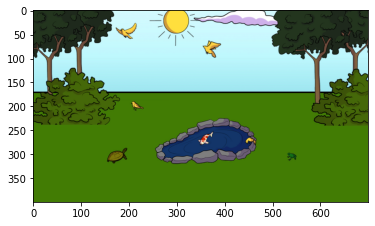

In [35]:
# Check a prediction
i = random.choice([x for x in range(len(df_test))])
[x_text,x_image] = load_image_to_predict(df_test, i, vocab_size, sequence_length, tokenizer = TOKEN)

# Show the correspondent image
fig, ax = plt.subplots(1, 1)
ax.imshow(np.uint8(x_image[0]))

# Show the predicted answer
print('\n\n','Question: ' + df_test.question[i])
for key in labels_dict: 
    if labels_dict[key] == d[df_test.question_id[i]]: 
        res = key 
print('\n','Answer: ' + res)